In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_features = pd.read_csv(r"1.1-Output/ProcessedFeatures.csv")
df_labels = pd.read_csv(r"1.1-Output/ProcessedLabels.csv")
df_attempted = pd.read_csv(r"1.1-Output/ProcessedAttemptedBool.csv")

In [3]:
df_labels.loc[df_attempted['Attempted Category'] != -1, 'Label'] = 'BENIGN'

In [4]:
df_features.drop(columns=['ICMP Code', 'ICMP Type', 'Src Port', 'Dst Port', 'Protocol', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count'], inplace=True)

In [5]:
# Combine into a single DataFrame
df = df_features.copy()
df['Label'] = df_labels.iloc[:, 0]  # Add target column

In [6]:
# Encode the categorical target into numeric (required for Pearson correlation)
df['Label'] = df['Label'].astype('category').cat.codes

In [7]:
correlation_matrix_full = df.corr().abs()
corr_with_target = correlation_matrix_full['Label'].drop('Label')
correlation_matrix = df_features.corr().abs()

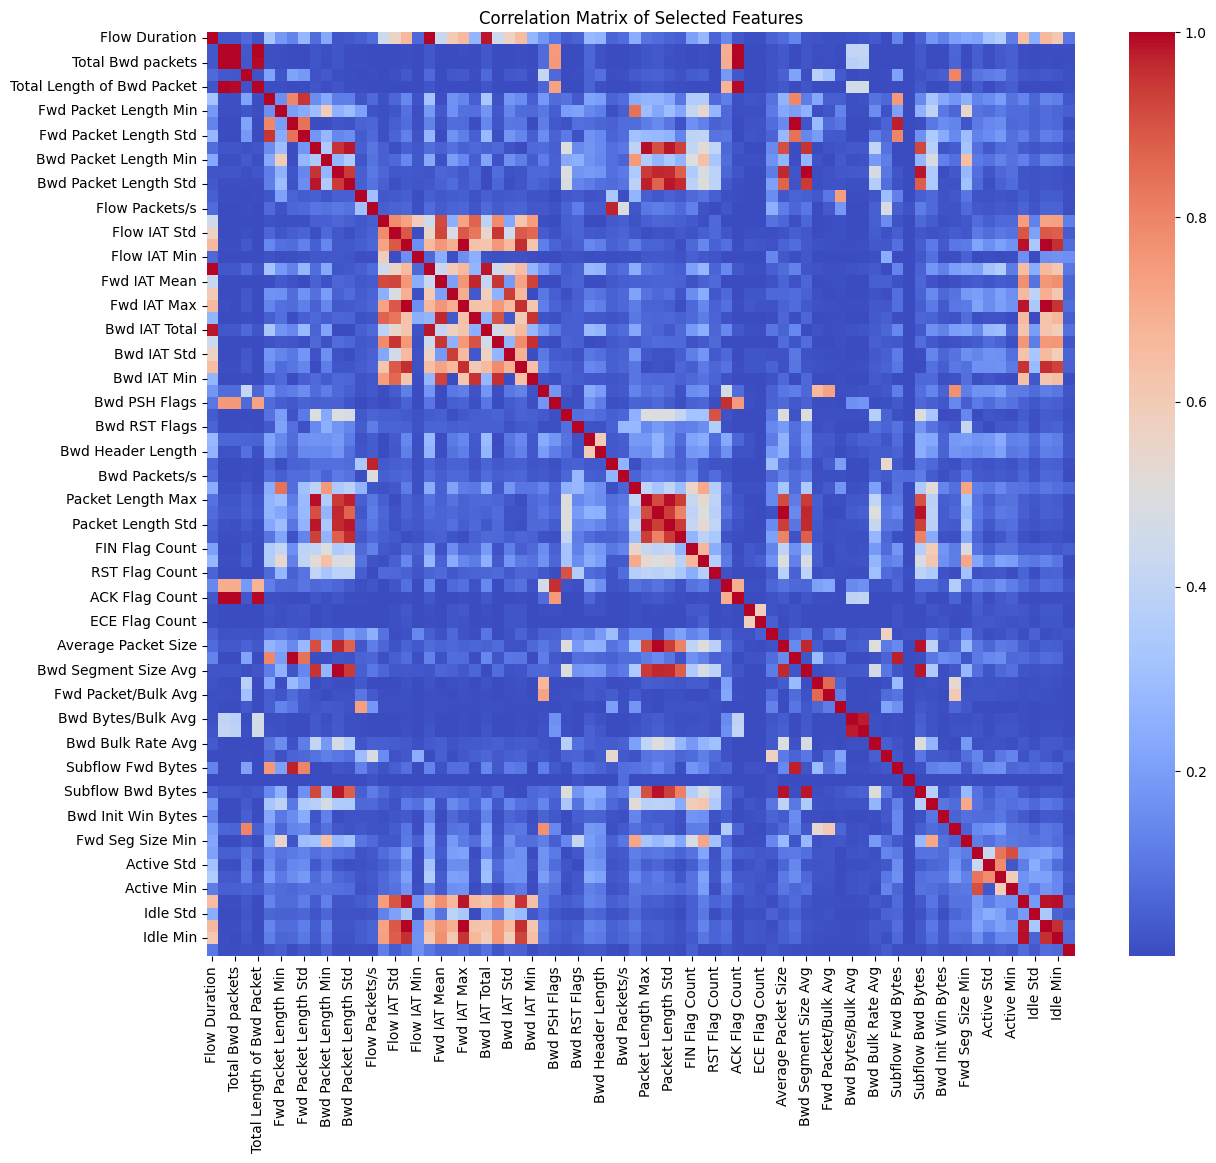

In [49]:
# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix of Selected Features")
# plt.tight_layout()
plt.show()

### GREEDY FORWARD SELECTION

In [63]:
def greedy_forward_selection(corr_matrix, corr_with_target, tolerance=1e-3):
    """
    Performs correlation-based Greedy Forward Selection.

    Parameters:
    -----------
    corr_matrix : pd.DataFrame
        Pairwise correlation matrix of features.
    corr_with_target : pd.Series
        Correlation of each feature with the target label.
    tolerance : float
        Minimum improvement in merit required to continue selection.

    Returns:
    --------
    selected_features : list
        Ordered list of selected features.
    avg_corr : float
        Average pairwise correlation of selected features.
    """
    remaining_features = list(corr_with_target.index)
    selected_features = []
    prev_best_merit = 0
    # uncomment to control the effect of inter-feature redundancy
    alpha = 0.1

    while remaining_features:
        best_merit = -1
        best_feature = None

        for feature in remaining_features:
            k = len(selected_features) + 1

            # Relevance with target
            r_cf = (sum(corr_with_target[f] for f in selected_features) + corr_with_target[feature]) / k

            # Redundancy with selected
            if len(selected_features) == 0:
                r_ff = 0
            else:
                temp_set = selected_features + [feature]
                r_vals = [
                    corr_matrix.loc[temp_set[i], temp_set[j]]
                    for i in range(len(temp_set))
                    for j in range(i + 1, len(temp_set))
                ]
                r_ff = np.mean(r_vals) if r_vals else 0

            # Merit Function
            # merit = (k * r_cf) / np.sqrt(k + k * (k - 1) * r_ff) if r_ff < 1 else 0
            # uncomment to control the effect of inter-feature redundancy
            merit = (k * r_cf) / np.sqrt(k + k * alpha * (k - 1) * r_ff) if r_ff < 1 else 0

            if merit > best_merit:
                best_merit = merit
                best_feature = feature

        if best_merit - prev_best_merit < tolerance:
            break

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        prev_best_merit = best_merit

    # Compute final average pairwise correlation of selected features
    if len(selected_features) > 1:
        selected_corr = corr_matrix.loc[selected_features, selected_features]
        avg_corr = selected_corr.where(
            np.triu(np.ones(selected_corr.shape), k=1).astype(bool)
        ).mean().mean()
    else:
        avg_corr = 0.0

    return selected_features, avg_corr


In [64]:
selected_features_1, avg_corr_1 = greedy_forward_selection(
    correlation_matrix, 
    corr_with_target,
    tolerance=1e-4)

print(f"Selected Features ({(len(selected_features_1))}):\n{selected_features_1}")

print("\nAverage Correlation (after reduction):", avg_corr_1)

Selected Features (13):
['Bwd RST Flags', 'Fwd Seg Size Min', 'Packet Length Min', 'RST Flag Count', 'Flow Packets/s', 'Bwd Packet Length Min', 'Bwd Packets/s', 'Fwd Packet Length Min', 'Fwd Packets/s', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Fwd Packet Length Mean', 'SYN Flag Count']

Average Correlation (after reduction): 0.25888783374224744


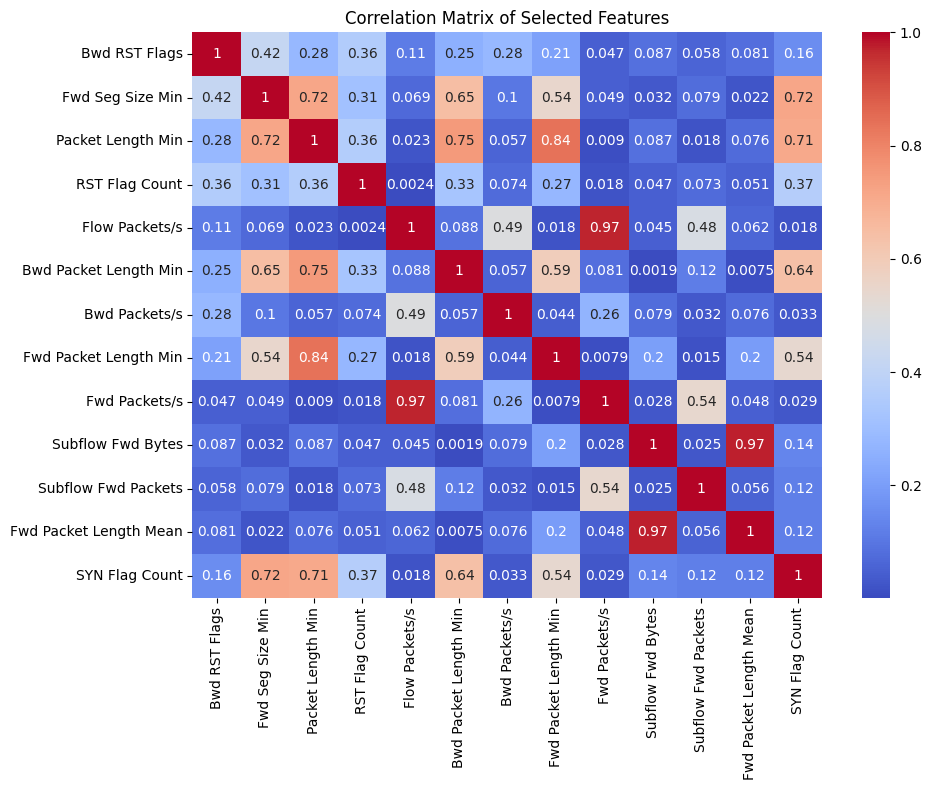

In [65]:
# Compute correlation matrix for selected features
selected_corr_matrix = df[selected_features_1].corr().abs()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix of Selected Features")
plt.tight_layout()
plt.show()

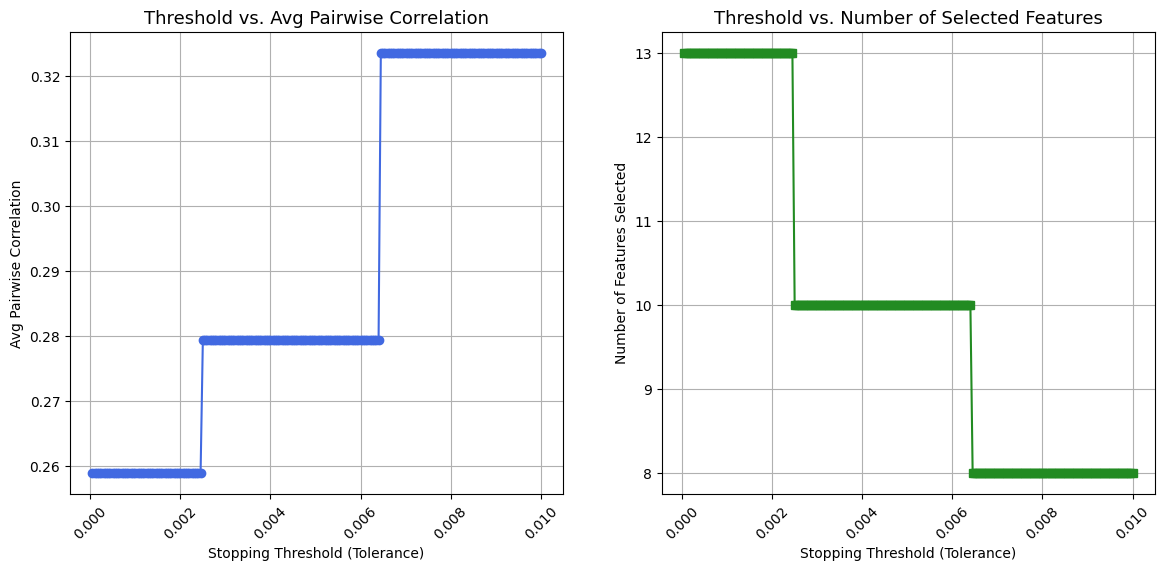

In [68]:
thresholds = np.linspace(5e-5, 1e-2, 200)
# thresholds = np.linspace(1e-4, 1e-2, 100)

avg_corrs = []
num_selected = []

for tol in thresholds:
    selected_feats, avg_corr = greedy_forward_selection(
        corr_matrix=correlation_matrix,
        corr_with_target=corr_with_target,
        tolerance=tol
    )
    avg_corrs.append(avg_corr)
    num_selected.append(len(selected_feats))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(thresholds, avg_corrs, marker='o', color='royalblue')
axes[0].set_title("Threshold vs. Avg Pairwise Correlation", fontsize=13)
axes[0].set_xlabel("Stopping Threshold (Tolerance)")
axes[0].set_ylabel("Avg Pairwise Correlation")
axes[0].grid(True)

axes[1].plot(thresholds, num_selected, marker='s', color='forestgreen')
axes[1].set_title("Threshold vs. Number of Selected Features", fontsize=13)
axes[1].set_xlabel("Stopping Threshold (Tolerance)")
axes[1].set_ylabel("Number of Features Selected")
axes[1].grid(True)

axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

plt.show()

### THRESHOLD-BASED SELECTION

In [54]:
def correlation_fs_max_redundancy(corr_matrix, corr_with_target, alpha=0.3):
    """
    Greedy forward selection using maximum allowed pairwise correlation (alpha)
    to limit redundancy.

    Parameters:
    -----------
    corr_matrix : pd.DataFrame
        Correlation matrix of features.
    corr_with_target : pd.Series
        Correlation of each feature with the target.
    alpha : float
        Maximum allowed correlation between selected features.

    Returns:
    --------
    selected_features : list
        Final list of selected features.
    avg_corr : float
        Average pairwise correlation of selected features.
    """
    remaining = corr_with_target.sort_values(ascending=False).index.tolist()
    selected = []

    for feature in remaining:
        if not selected:
            selected.append(feature)
            continue

        # Check correlation with already selected features
        redundant = False
        for sel_feat in selected:
            if abs(corr_matrix.loc[feature, sel_feat]) > alpha:
                redundant = True
                break

        if not redundant:
            selected.append(feature)

    # Compute average pairwise correlation
    if len(selected) > 1:
        selected_corr = corr_matrix.loc[selected, selected]
        avg_corr = selected_corr.where(np.triu(np.ones(selected_corr.shape), k=1).astype(bool)).mean().mean()
    else:
        avg_corr = 0.0

    return selected, avg_corr

In [61]:
selected_features_2, avg_corr_2 = correlation_fs_max_redundancy(
    correlation_matrix, 
    corr_with_target, 
    alpha=0.2
)

print("Selected Features:", selected_features_2)
print("Number of Features:", len(selected_features_2))
print("Avg Correlation (Redundancy):", avg_corr_2)

Selected Features: ['Bwd RST Flags', 'Flow Packets/s', 'SYN Flag Count', 'Subflow Fwd Bytes', 'Flow IAT Max', 'Fwd Act Data Pkts', 'Bwd Init Win Bytes', 'Bwd Header Length', 'Active Min', 'Active Std', 'Bwd PSH Flags', 'Total TCP Flow Time', 'Flow IAT Min', 'Fwd Bulk Rate Avg', 'Bwd Packet/Bulk Avg', 'CWR Flag Count', 'Subflow Bwd Packets']
Number of Features: 17
Avg Correlation (Redundancy): 0.062404516950244786


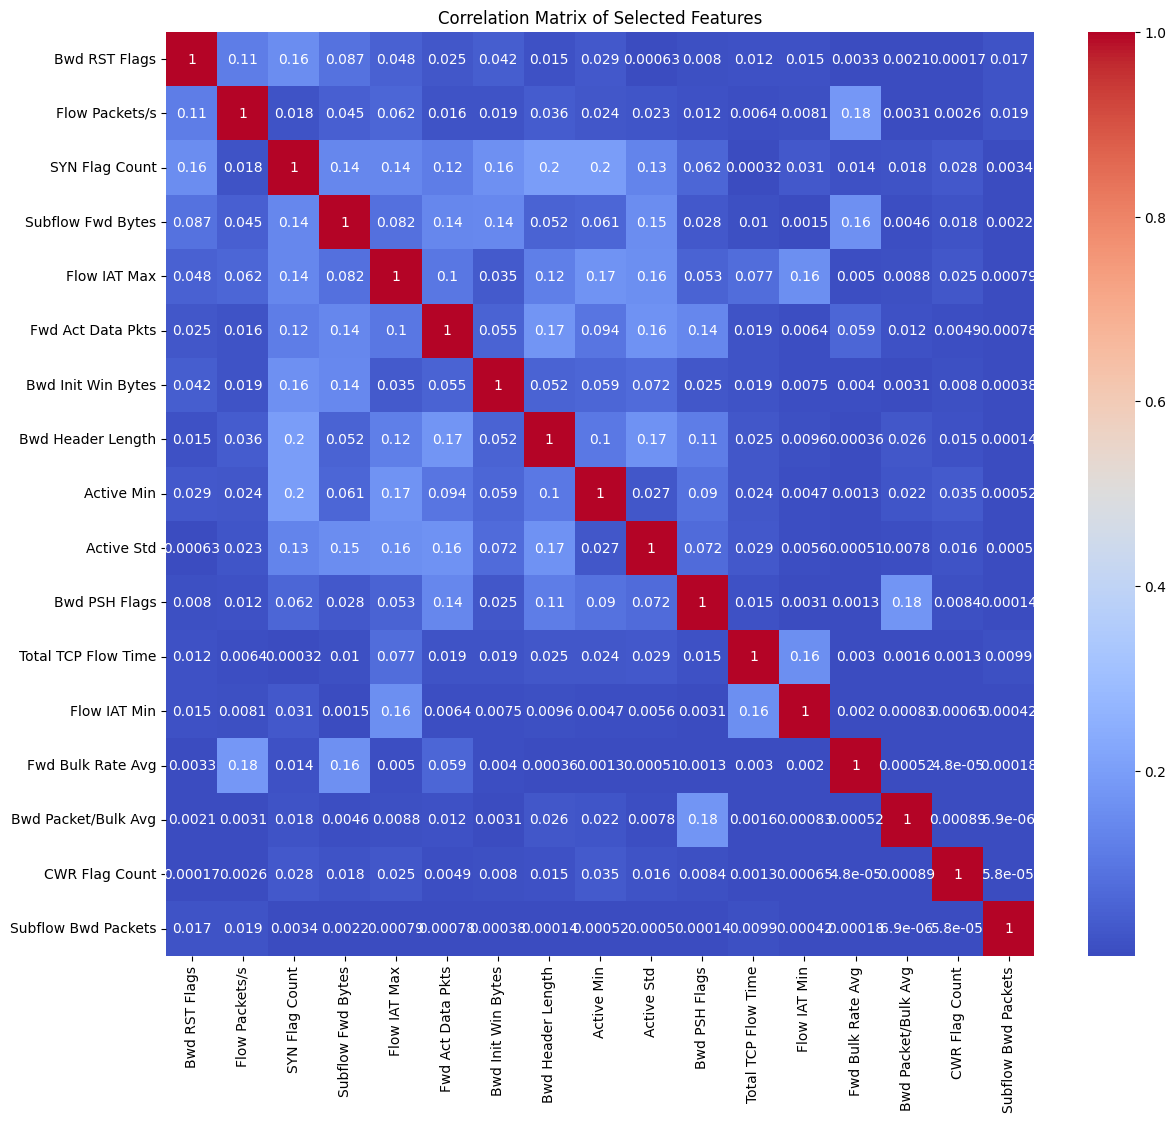

In [ ]:
# Compute correlation matrix for selected features
selected_corr_matrix_2 = df[selected_features_2].corr().abs()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(selected_corr_matrix_2, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix of Selected Features")
# plt.tight_layout()
plt.show()

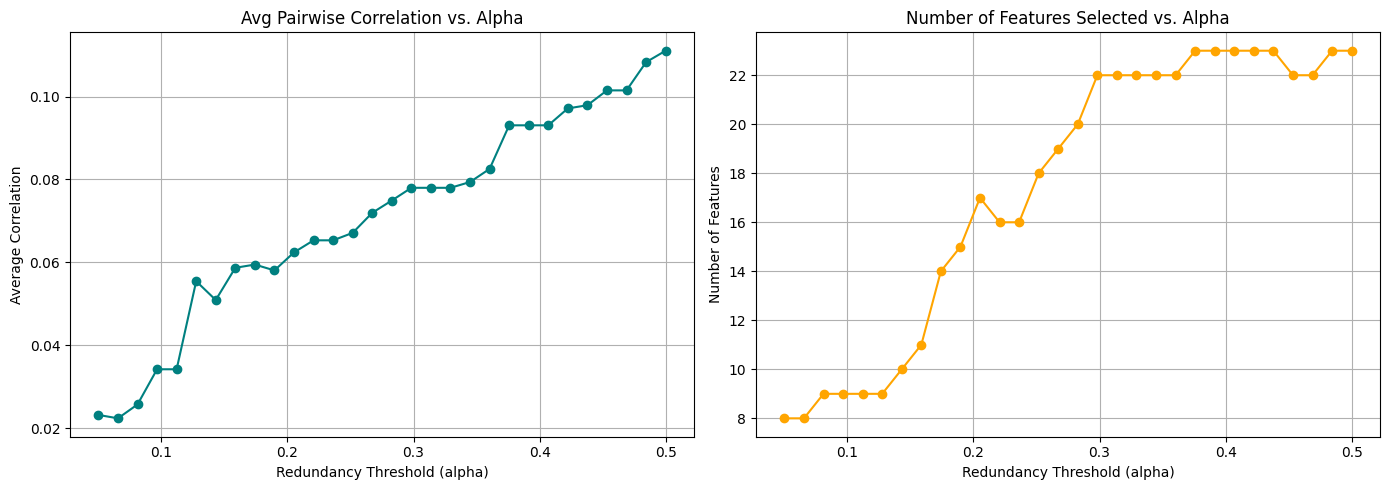

In [69]:
alphas = np.linspace(0.05, 0.5, 30)
avg_corrs = []
num_features = []

for alpha in alphas:
    selected, avg_corr = correlation_fs_max_redundancy(correlation_matrix, corr_with_target, alpha=alpha)
    avg_corrs.append(avg_corr)
    num_features.append(len(selected))

# ----- Plotting -----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Avg Corr vs. Alpha
axes[0].plot(alphas, avg_corrs, marker='o', color='teal')
axes[0].set_title("Avg Pairwise Correlation vs. Alpha")
axes[0].set_xlabel("Redundancy Threshold (alpha)")
axes[0].set_ylabel("Average Correlation")
axes[0].grid(True)

# Number of Features vs. Alpha
axes[1].plot(alphas, num_features, marker='o', color='orange')
axes[1].set_title("Number of Features Selected vs. Alpha")
axes[1].set_xlabel("Redundancy Threshold (alpha)")
axes[1].set_ylabel("Number of Features")
axes[1].grid(True)

plt.tight_layout()
plt.show()